# Imports

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
from FittedModels.utils import plot_distributions
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.MoG import MoG
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils import plot_func2D, MC_estimate_true_expectation, plot_distribution
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.train_AIS import AIS_trainer
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
import torch

# Expectation Function and Key Param

In [5]:
def expectation_function(x):
    A = torch.ones((x.shape[-1], x.shape[-1]))
    return torch.einsum("bi,ij,bj->b", x, A, x)

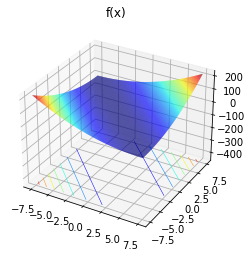

In [6]:
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

## Key param

In [7]:
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=5)

In [ ]:
fig = plot_distribution(target)

## MC Estimate of true expectation

In [8]:
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
true_expectation

tensor(13.1823)

# First Let's estimate this distribution with a diagonal Guassian

## DReG

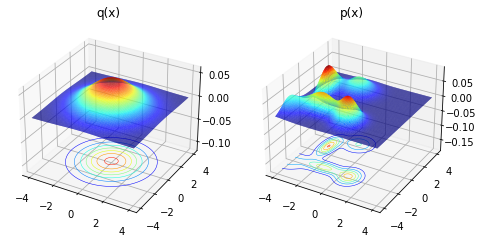

In [7]:
learnt_sampler = DiagonalGaussian(dim=dim)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
fig_before = fig_before_train = plot_distributions(tester)
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: 11.637343406677246, mean log p_x -5.459105491638184: 100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 277.82it/s]


true expectation is 13.18234920501709 
estimate before training is 10.94054126739502 
estimate after training is 9.18449592590332 
effective sample size is 851.39013671875 
variance in weights is 1.0746573053665998e-07


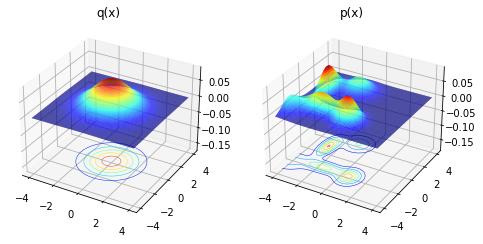

In [8]:
history = tester.train(epochs)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"true expectation is {true_expectation} \n"
      f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")
fig_after_train = plot_distributions(tester)

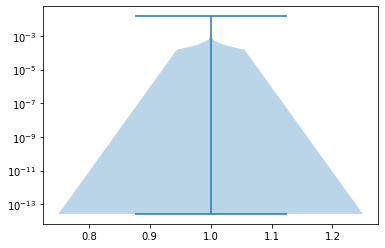

In [9]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

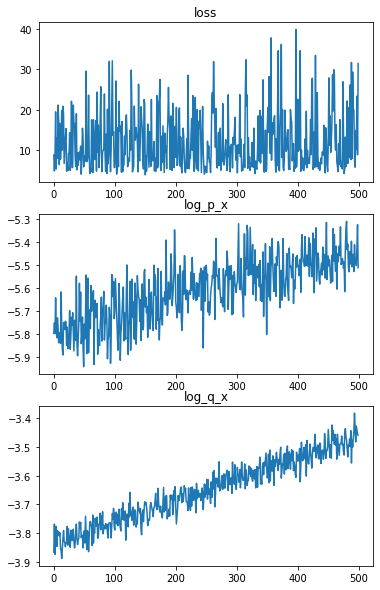

In [10]:
plot_history(history)

## KL

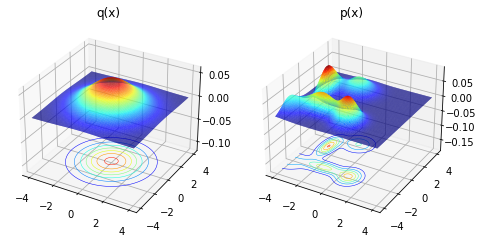

In [11]:
learnt_sampler = DiagonalGaussian(dim=dim)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
fig_before = fig_before_train = plot_distributions(tester)
expectation_before, sampling_weights_before = tester.estimate_expectation()

loss: 2.548232316970825, mean log p_x -6.851799488067627: 100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 299.16it/s]


true expectation is 13.18234920501709 
estimate before training is -2.1774823665618896 
estimate after training is -2.37692928314209 
effective sample size is 2463.1142578125 
variance in weights is 3.0602066658502736e-08


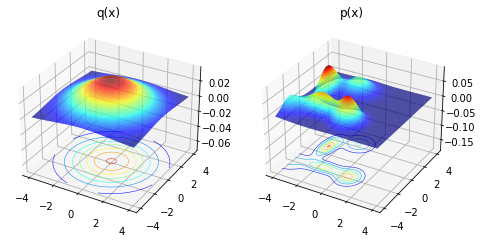

In [12]:
history = tester.train(epochs)
expectation, info = tester.estimate_expectation(n_samples_estimation)
print(f"true expectation is {true_expectation} \n"
      f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")
fig_after_train = plot_distributions(tester)

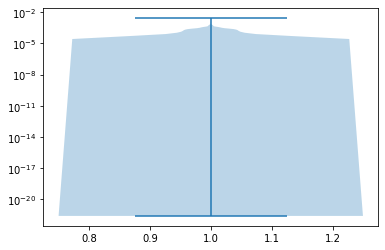

In [13]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

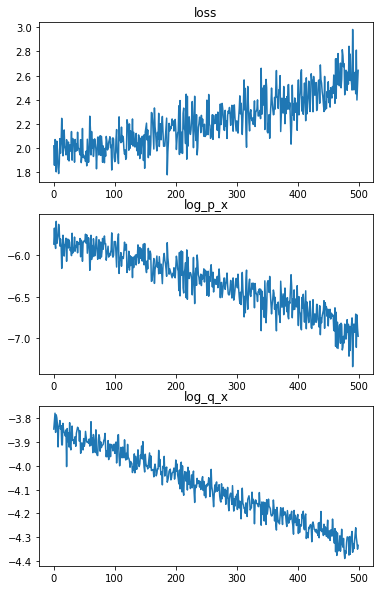

In [14]:
plot_history(history)

# Annealed Importance Sampling

In [15]:
from ImportanceSampling.AnnealedImportanceSampler import AnnealedImportanceSampler

In [16]:
annealed_importance_sampler = AnnealedImportanceSampler(tester.learnt_sampling_dist, tester.target_dist)
expectation, info_dict = annealed_importance_sampler.calculate_expectation(n_samples_estimation, expectation_function)

In [17]:
info_dict['effective_sample_size'] # so close to number of samples!

tensor(9715.2148, grad_fn=<MulBackward0>)

In [18]:
info_dict['normalised_sampling_weights'] = info_dict['normalised_sampling_weights'].detach()

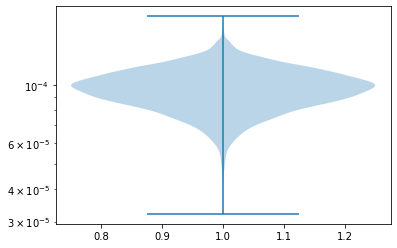

In [19]:
plt.violinplot([info_dict['normalised_sampling_weights'].detach()])
plt.yscale("log")

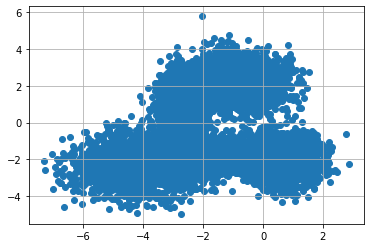

In [20]:
plt.scatter(info_dict["samples"][:, 0], info_dict["samples"][:, 1])
plt.grid()

# Flow

## KL

In [12]:
learnt_sampler = FlowModel(x_dim=dim, flow_type="RealNVP", n_flow_steps=10)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

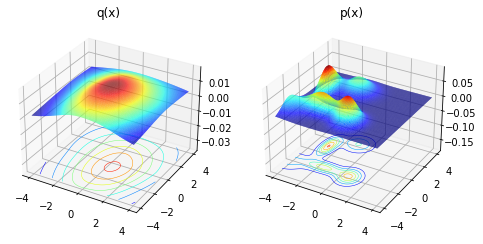

In [13]:
fig_before_train = plot_distributions(tester)

In [14]:
history = tester.train(epochs, batch_size=1000)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

loss: 33.54325866699219, mean log p_x -38.754600524902344:   0%|▎                                                                                      | 2/500 [00:00<00:32, 15.10it/s]


Exception: NaN loss encountered

In [ ]:
fig_after_train = plot_distributions(tester)

In [ ]:
plot_history(history)

## DReG

In [15]:
learnt_sampler = FlowModel(x_dim=dim, flow_type="RealNVP", n_flow_steps=10)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

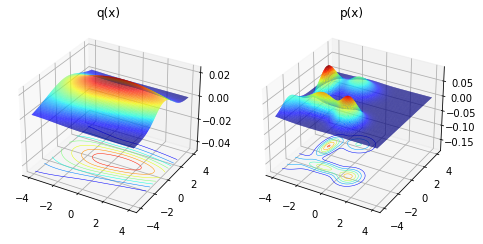

In [16]:
fig_before_train = plot_distributions(tester)

In [17]:
history = tester.train(epochs, batch_size=1000)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

loss: -16.989572525024414, mean log p_x -3.4141485691070557: 100%|███████████████████████████████████████████████████████████████████████████████████| 500/500 [00:20<00:00, 24.39it/s]

estimate before training is 13.403790473937988 
estimate after training is 7.228132724761963 
effective sample size is 10.81612491607666 
variance in weights is 9.236378900823183e-06


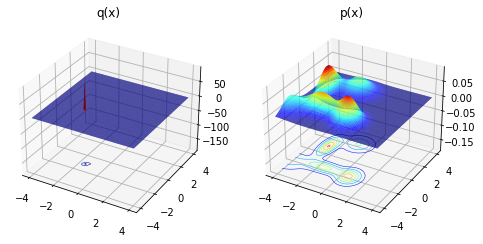

In [18]:
fig_after_train = plot_distributions(tester)

(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

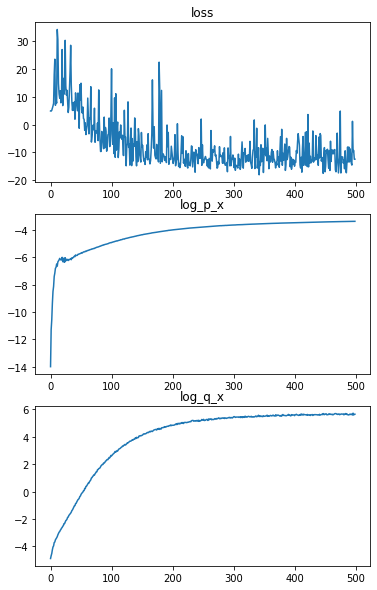

In [19]:
plot_history(history)

# DReG + AIS + Flow

In [31]:
from FittedModels.train_AIS import AIS_trainer

In [20]:
learnt_sampler = FlowModel(x_dim=dim, flow_type="RealNVP", n_flow_steps=20)
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=10, n_updates_Metropolis=1)
history = tester.train(500, batch_size=300)

loss: 5.218505859375, mean log p_x -4.165732383728027: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:28<00:00,  1.12it/s]


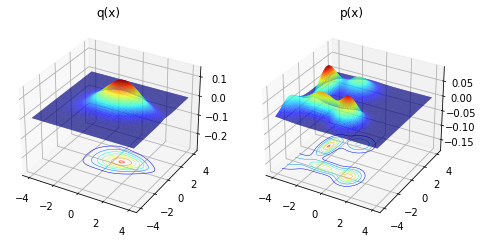

In [21]:
fig_after_train = plot_distributions(tester)